# 第5章 ロジスティック回帰とROC曲線：学習モデルの評価方法

## 5.1 分類問題への最尤推定法の適用

**[05LP-01]**

必要なモジュールをインポートします。

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import multivariate_normal

**[05LP-02]**

トレーニングセットのデータを生成する関数を用意します。

平面上の ○ ☓ の 2 種類のデータについて、それぞれの「個数、中心座標、分散」を引数で指定します。

In [10]:
def prepare_dataset(n1, mu1, variance1, n2, mu2, variance2):
  df1 = DataFrame(multivariate_normal(mu1, np.eye(2)*variance1 ,n1),
                  columns=['x', 'y'])
  df1['type'] = 1
  df2 = DataFrame(multivariate_normal(mu2, np.eye(2)*variance2, n2),
                  columns=['x', 'y'])
  df2['type'] = -1
  df = pd.concat([df1, df2], ignore_index=True)
  df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
  return df

**[05LP-03]**

パーセプトロンによる分類を実施する関数を用意します。

トレーニングセットのデータを受け渡すと、下記の一次関数 $f(x,\,y)$ に対するパラメーター $(w_0,\,w_1,\,w_2)$ を格納した array オブジェクトを返します。

$$ f(x,\,y) = w_0 + w_1x + w_2y$$

※ 学習処理の際は、下記のバイアス項 $b$ を利用しますが、最終結果としては、$w_0b$ を $w_0$ として返しています。

$$ f(x,\,y) = w_0b + w_1x + w_2y,\ \ b = \frac{1}{2N}\sum_{n=1}^N(|x_n|+|y_n|)$$



In [11]:
def run_perceptron(train_set):
  # パラメータの初期値とbias項の設定
  w0 = w1 = w2 = 0.0
  bias = 0.5 * (train_set.x.abs().mean() + train_set.y.abs().mean())

  # Iterationを実施
  for i in range(30):
    for index, point in train_set.iterrows():
      x, y, type = point.x, point.y, point.type
      if (w0*bias + w1*x + w2*y) * type <= 0:
        w0 += type * bias
        w1 += type * x
        w2 += type * y

  return np.array([w0*bias, w1, w2])

**[05LP-04]**

ロジスティック回帰で分割線を決定する関数を用意します。

トレーニングセットのデータを受け渡すと、下記の一次関数 $f(x,\,y)$ に対するパラメーター $(w_0,\,w_1,\,w_2)$ を格納した array オブジェクトを返します。

$$ f(x,\,y) = w_0 + w_1x + w_2y$$

学習時は、本文で説明した、次の関係式でパラメータ $\mathbf w=(w_0,\,w_1,\,w_2)^{\rm T}$ を更新する処理（IRLS法）を最大で30回繰り返します。

$$
\mathbf w_{\rm{new}} = \mathbf w_{\rm{old}} - (\boldsymbol\Phi^{\rm T}\mathbf R\boldsymbol\Phi)^{-1}\boldsymbol\Phi^{\rm T}(\mathbf z-\mathbf t)
$$

In [12]:
def run_logistic(train_set):
  w = np.array([0, 0, 0])
  phi = train_set[['x', 'y']]
  phi['bias'] = 1
  phi = phi[['bias', 'x', 'y']].values
  t = (train_set['type'].values+1)*0.5 # type = 1, -1 を type = 1, 0 に変換

  # 最大30回のIterationを実施
  for i in range(30):
    # IRLS法によるパラメータの修正
    z = np.array([1.0/(1.0+np.exp(-np.dot(w, line))) for line in phi])
    r = np.diag(z*(1-z)) 
    tmp1 = np.linalg.inv(np.dot(np.dot(phi.T, r), phi))
    tmp2 = np.dot(phi.T, (z-t))
    w_new = w - np.dot(tmp1, tmp2)
    # パラメータの変化が 0.1% 未満になったら終了
    if np.dot(w_new-w, w_new-w) < 0.001*np.dot(w, w):
      break
    w = w_new

  return w

**[05LP-05]**

結果をグラフに表示する関数を用意します。

In [13]:
# 判定誤差の計算
def err_rate(w0, w1, w2):
  err = 0.0
  for index, point in train_set.iterrows():
    x, y, type = point.x, point.y, point.type
    if (w0 + w1*x + w2*y) * type <= 0:
      err += 1
  return err * 100 / len(train_set)

# 結果の表示
def show_result(subplot, train_set, w_logistic, w_perceptron):
  train_set1 = train_set[train_set['type']==1]
  train_set2 = train_set[train_set['type']==-1]
  ymin, ymax = train_set.y.min()-5, train_set.y.max()+10
  xmin, xmax = train_set.x.min()-5, train_set.x.max()+10

  subplot.tick_params(axis='x', labelsize=10)
  subplot.tick_params(axis='y', labelsize=10)
  subplot.set_ylim([ymin-1, ymax+1])
  subplot.set_xlim([xmin-1, xmax+1])
  subplot.scatter(train_set1.x, train_set1.y, marker='o', s=10, label=None)
  subplot.scatter(train_set2.x, train_set2.y, marker='x', s=10, label=None)

  w0, w1, w2 = w_logistic.tolist()
  linex = np.arange(xmin-5, xmax+5)
  liney = - linex * w1 / w2 - w0 / w2
  label = "Logistic Regression: ERR %.2f%%" % err_rate(w0, w1, w2)
  subplot.plot(linex, liney, label=label, color='red')

  w0, w1, w2 = w_perceptron.tolist()
  liney = - linex * w1 / w2 - w0 / w2
  label = "Perceptron:              ERR %.2f%%" % err_rate(w0, w1, w2)
  subplot.plot(linex, liney, label=label, linestyle='--', color='red')

  subplot.legend(loc=1, fontsize=10)

**[05LP-06]**

トレーニングセットのデータを生成して、ロジスティック回帰、および、パーセプトロンによる分類結果を表示します。

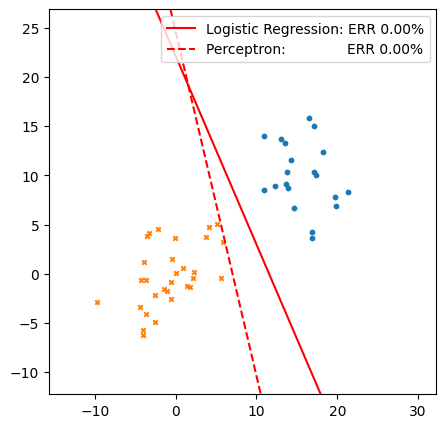

In [14]:
train_set = prepare_dataset(20, [15, 10], 10, 30, [0, 0], 10)
w_logistic = run_logistic(train_set)
w_perceptron = run_perceptron(train_set)
fig = plt.figure(figsize=(5, 5))
subplot = fig.add_subplot(1, 1, 1)
show_result(subplot, train_set, w_logistic, w_perceptron)

**[05LP-07]**

先ほどよりも分散が大きく、分類な困難なトレーニングセットを用意して、同様に、ロジスティック回帰、および、パーセプトロンによる分類結果を表示します。

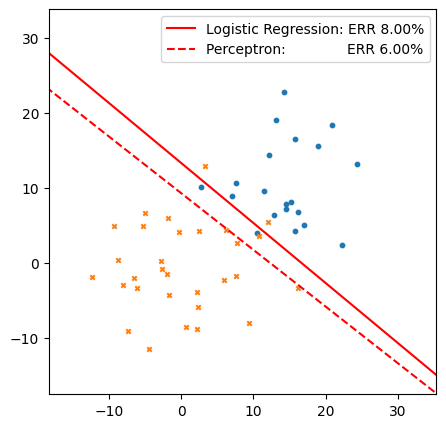

In [15]:
train_set = prepare_dataset(20, [15,10], 35, 30, [0,0], 35)
w_logistic = run_logistic(train_set)
w_perceptron = run_perceptron(train_set)
fig = plt.figure(figsize=(5, 5))
subplot = fig.add_subplot(1, 1, 1)
show_result(subplot, train_set, w_logistic, w_perceptron)